In [54]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats

import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from IPython.display import Image
from PIL import Image as PIL_Image
import io

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from IPython.display import Image

from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

##### Load Data

In [55]:
# Load dataset
# URL: https://www.kaggle.com/competitions/titanic/data

df_titanic = pd.read_csv(r"C:\Users\Deomar Santos\Desktop\Development Plan\Machine Learning\Decision Trees and Logistic Regression - Titanic\Titanic\Titanic-Dataset.csv", sep=',')

In [56]:
# List of variables

# Variable        Definition          Key
# survival        Survival            0 = No, 1 = Yes
# pclass          Ticket class        1 = 1st, 2 = 2nd, 3 = 3rd
# sex             Sex
# Age             Age in years
# sibsp           # of siblings / spouses aboard the Titanic	
# parch           # of parents / children aboard the Titanic	
# ticket          Ticket number
# fare            Passenger fare
# cabin	          Cabin number
# embarked        Port of Embarkation  C = Cherbourg, Q = Queenstown, S = Southampton

In [57]:
## Check the variables and the presence of null values

# The columns that have null values are:
# Age, Cabin and Embarked

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##### Transform Data

In [58]:
# Age

In [59]:
print("% of null data in column 'Age': ", round((df_titanic['Age'].isnull().sum()/len(df_titanic)*100), 2))

% of null data in column 'Age':  19.87


In [60]:
# As we have 20% of age data missing, we are going to replace the null values with the mean age in order to not change the statistics of the column by transforming.
# Note: this is one of the main methods used for working with age data

In [61]:
# Replace the null values with the mean age
df_titanic['Age'] = df_titanic['Age'].fillna(df_titanic['Age'].mean())

In [62]:
# Embarked

In [63]:
print("% of null data in column 'Embarked': ", round((df_titanic['Embarked'].isnull().sum()/len(df_titanic)*100), 2))

% of null data in column 'Embarked':  0.22


In [64]:
# In this case less than 3% of the data is missing, so we could just delete that data, but instead, in order to preserve the other information of those data, we are going to use another method

In [65]:
# We can notice that most part of passenger Embarked in 'Southampton' (72%), so a good approach would be replace the missing data with the most frequent data (Southampton)

print(df_titanic.groupby(by=['Embarked']).count()['PassengerId'].sort_values(ascending=False)/df_titanic.groupby(by=['Embarked']).count()['PassengerId'].sort_values(ascending=False).sum()*100)

Embarked
S    72.440945
C    18.897638
Q     8.661417
Name: PassengerId, dtype: float64


In [66]:
# Replace the missing data with the most frequent data (Southrampton)

df_titanic['Embarked'] = df_titanic['Embarked'].fillna(df_titanic.groupby(by=['Embarked']).count()['PassengerId'].sort_values(ascending=False)[:1].index[0])

In [67]:
# Cabin

In [68]:
print("% of null data in column 'Cabin': ", round(df_titanic['Cabin'].isnull().sum()/len(df_titanic)*100, 2))

% of null data in column 'Cabin':  77.1


In [69]:
# Most of the 'Cabin' data is missing (77%) so is better just drop this column because likely there is not a way to replace the missing data in order to improve the analysis

In [70]:
# Drop the 'Cabin' column

df_titanic = df_titanic.drop(columns=['Cabin'])

In [71]:
# Now we have all the data complete in the dataset

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


##### Basic Descriptive analysis

In [72]:
# In order to understand the relationship between the survive and the other variables, let's create some assumptions and validate them

In [73]:
# Maybe there is a relationship between how much money someone pays for the ticket and the probability to survive, given that theoretically
# richer groups have advantages. To validate this, let's split fare in different ranges

In [74]:
# To define the range, one approach is to define ranges between the minimum and maximum fares
print('Maximum Fare : ', round(df_titanic['Fare'].max(), 2))
print('Minimum Fare : ', round(df_titanic['Fare'].min(), 2))

Maximum Fare :  512.33
Minimum Fare :  0.0


In [75]:
# Defining equally spaced intervals with the step of 15 USD 

split_range = np.array([0, 20, 40, 60, 80])

In [76]:
# Labeling every passenger regarding to the fare paid

def return_chunks(data, data_range):
    for chunk_point in split_range[::-1]:
        if (data >= chunk_point):
            return chunk_point
#df_titanic['FareChunks'] = df_titanic['Fare'].apply(return_chunks, data_range=split_range)
df_titanic['FareChunks_Range'] = df_titanic['Fare'].apply(return_chunks, data_range=split_range)

In [77]:
# def split_range(data, chunks):
#     chunk_size = (data['Fare'].max() - data['Fare'].min())/chunks
# #     np.arange(data['Fare'].min(), data['Fare'].max(), chunk_size)
#     range_list = np.arange(data['Fare'].min(), data['Fare'].max(), chunk_size)[::-1]
#     return range_list

# range_list = split_range(df_titanic, 5)

In [78]:
# Calculating the percentage of survival by group we notice that as much as you pay the more likely are you to survive, except for passenger
# that paied between 40-60

# This is an indicative that could be another variable that changes this pattern in the 40-60 group

df_titanic.groupby(by=['FareChunks_Range'])['Survived'].sum()/df_titanic.groupby(by=['FareChunks_Range'])['Survived'].count()*100

FareChunks_Range
0     27.766990
20    43.000000
40    57.407407
60    50.000000
80    77.631579
Name: Survived, dtype: float64

In [79]:
# Another variable that we could check is if the child or not, given that the Titanic adopted the protocol to firstly save children and women 

# Just to check this main assumption, let's calculate the percentage of children and adults that survived
# for this first caclulation we will consider a child as <= 12 year and adult < 12 year

In [80]:
# Label the passenger as child or an adult
df_titanic['Maturity'] = df_titanic['Age'].apply(lambda x : 'Child' if x <= 12 else ('Adult' if x > 12 else np.nan))

In [81]:
# Calculating the percentage of children and adults that survived we can see that being a child has a higher chance of survive
df_titanic.groupby(by=['Maturity'])['Survived'].sum()/df_titanic.groupby(by=['Maturity'])['Survived'].count()*100

Maturity
Adult    36.739659
Child    57.971014
Name: Survived, dtype: float64

In [82]:
# Now calculating the percentage of children per fare range wee see that the fare group of 60-80 probably has less chance to survive because there are only adults on this group

df_titanic.groupby(by=['FareChunks_Range',  'Maturity'])['Survived'].count()/df_titanic.groupby(by=['FareChunks_Range'])['Maturity'].apply(lambda x : x.notnull().sum())*100

FareChunks_Range  Maturity
0                 Adult        95.922330
                  Child         4.077670
20                Adult        80.000000
                  Child        20.000000
40                Adult        92.592593
                  Child         7.407407
60                Adult       100.000000
80                Adult        94.736842
                  Child         5.263158
dtype: float64

In [83]:
# Another variable that we could check is if the passenger is woman or man, given that the Titanic adopted the protocol adopted

# Just to check this main assumption, let's calculate the percentage of women and men that survived

In [84]:
# As we can see, the probability to survive is much bigger if the passenger is a woman, another variable that change influence the survival probability for each fare range

df_titanic.groupby(by=['Sex'])['Survived'].sum()/df_titanic.groupby(by=['Sex'])['Survived'].count()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [85]:
# Given that we have more than 8 variables there could be a lof of combinations that would make very difficult to classify groups that are
# prone to survive. The above exploration was just one example of how the variables can interact e influence each other to compose the 
# final outcome

# To make the analysis reliable we have to adopt a method to analyze the variables and their relationships in a way that we can standartize

# For this, let's use the correlation calculation, which will give us how strong the variables relate with the probability to survive, this 
# will give us a method to classify the relationship by the same patterns

In [86]:
# For this we are going to use the Point-Biserial to calculate the correlation between continuum and categorical variables
# and the Point-Biserial correlation to calculate the correlation between two categorical variables

In [87]:
# Let's start with the relationship between 'Fare' and 'Survived':

In [88]:
# Correlation between 'Fare' and 'Survived' variable:

print("Correlation (Survived-Fare): ", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Fare'])[0], 2), "\n"
      "p-value: ", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Fare'])[1])

Correlation (Survived-Fare):  0.26 
p-value:  6.12018934191834e-15


In [89]:
# Fare seems to have a medium correlation, in other words, the fact of paying more money for the travel imply that you are likely to survive. 
# So somehow people that have more money were prioritized to get the boats for example

In [90]:
# For the correlation between 'Age' and 'Survived' we see that the correlation is not strong as the correlation between begin a child or not, given that the protocol 
# was adopt for children, so doesn't depend strictly on ages

In [91]:
print("Correlation (Survived-Age): ", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Age'])[0], 2), "\n"
      "p-value: ", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Age'])[1])

Correlation (Survived-Age):  -0.07 
p-value:  0.03721708372681355


In [39]:
# The rest of the variables are categorical, for this we use other correlation calculation called 'Chi-Square', which calculates the correlation between two categorical variables
# But first we need to transform the categorical variables into integer so we can calculate the Chi-Square correlation

In [93]:
# For this we can use the function factorize that attributes an integer for every different text in the column. 
# Applying the factorize for every categorical column

# Embarked
df_titanic['Embarked_int'] = pd.factorize(df_titanic['Embarked'])[0]

# Ticket
df_titanic['Ticket_int'] = pd.factorize(df_titanic['Ticket'])[0]

# Sex
df_titanic['Sex_int'] = pd.factorize(df_titanic['Sex'])[0]

# Sex
df_titanic['Child'] = pd.factorize(df_titanic['Maturity'])[0]

In [41]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'FareChunks_Range', 'Maturity',
       'Embarked_int', 'Ticket_int', 'Sex_int', 'Child'],
      dtype='object')

In [95]:
# The rest of the variables are categorical, for this we use other correlation calculation called 'Chi-Square', which 
# calculates the correlation between two categorical variables
# Above we have the correlations ordered in descendent order along with the type of correlation applied

# Chi-Square Correlation

# Chi Square correlation between sex and survive
print("Chi-Square correlation (Survive-Sex)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Sex_int'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Sex_int'])[1], "\n")

# Chi-Square correlation between ticket class and survive
print("Chi-Square correlation (Survive-Ticket Class)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Pclass'])[0], 2), "\n",
     "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Pclass'])[1], "\n")

# Chi-Square correlation between ticket type and survive
print("Chi-Square correlation (Survived-Being a Child)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Child'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Child'])[1], "\n")

# Chi-Square correlation between embark origin and survive
print("Chi-Square correlation (Survived-Embarked Origin)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Embarked_int'])[0], 2), "\n",
     "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Embarked_int'])[1], "\n")

# Chi-Square correlation between ticket type and survive
print("Chi-Square correlation (Survived-Ticket Type)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Ticket_int'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Ticket_int'])[1], "\n")

print("----------------\n")

# Point-Biserial correlation between fare origin and survive
print("Point-Biserial correlation (Survived-Fare)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Fare'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Fare'])[1], "\n")

# Point-Biserial correlation between # of sons and parents and survive
print("Point-Biserial correlation (Survived-# Sons & Parents)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Parch'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Parch'])[1], "\n")

# Point-Biserial correlation between age origin and survive
print("Point-Biserial correlation (Survived-Age)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['Age'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['Age'])[1], "\n")

# Point-Biserial correlation between # of siblings and spouses and survive
print("Point-Biserial correlation (Survived-# Siblings & Spouses)", round(stats.pointbiserialr(df_titanic['Survived'], df_titanic['SibSp'])[0], 2), "\n", 
    "p-value", stats.pointbiserialr(df_titanic['Survived'], df_titanic['SibSp'])[1], "\n")

Chi-Square correlation (Survive-Sex) 0.54 
 p-value 1.406066130878715e-69 

Chi-Square correlation (Survive-Ticket Class) -0.34 
 p-value 2.537047387978631e-25 

Chi-Square correlation (Survived-Being a Child) 0.12 
 p-value 0.0004825951511510082 

Chi-Square correlation (Survived-Embarked Origin) 0.11 
 p-value 0.0014083124205684283 

Chi-Square correlation (Survived-Ticket Type) -0.05 
 p-value 0.15835561128996709 

----------------

Point-Biserial correlation (Survived-Fare) 0.26 
 p-value 6.12018934191834e-15 

Point-Biserial correlation (Survived-# Sons & Parents) 0.08 
 p-value 0.014799245374712763 

Point-Biserial correlation (Survived-Age) -0.07 
 p-value 0.03721708372681355 

Point-Biserial correlation (Survived-# Siblings & Spouses) -0.04 
 p-value 0.2922439286980196 



In [43]:
# From the above list we can notice that the variables 'Sex', 'Ticket Class', 'Being a Child' and 'Embarked Origin' have moderate to very weak (0.59 - 0) correlation
# by the Chi-Square with correlation and have small p-value
# whereas 'Fare', '# Sons & Parents' and 'Age' have have medium or weak and very weak correlation (0.39 - 0) and small p-values

# That's the variables that can tell better which passengers have higher probability to survive based on the data
# and are the variables that we are going to use in our prediction models

In [97]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'FareChunks_Range', 'Maturity',
       'Embarked_int', 'Ticket_int', 'Sex_int', 'Child'],
      dtype='object')

In [45]:
# Filtering the variables to use in the models
df_titanic = df_titanic[['Survived', 'Pclass', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked_int', 'Sex_int', 'Child']]

In [46]:
# Now that we have the variables with the higher correlation with the 'Survived' outcome, we are going to build a machine learning model with
# these variables in order to predict who is likely to survive based on the data available, as well as get insight from the models for how
# they choose the variable in order to predict the outcome

In [47]:
# The first model to be applied is the decision tree, a model the create a series of nodes that function as 'ifs' that lead to different
# outcomes based on the rules on each node that the model define based on the "correlation" of the variables with the outcome

In [48]:
# Decision tree model

In [99]:
# Split the data between predictor and target variables

# Predictor variable
df_titanic_predictor = df_titanic[['Pclass', 'Age', 'SibSp', 'Parch',
    'Fare', 'Child', 'Embarked_int', 'Sex_int']]

# Target variable
df_titanic_target = df_titanic['Survived']

# Split between test and train variables
X_train, X_test, y_train, y_test = train_test_split(df_titanic_predictor, df_titanic_target, test_size=0.3, random_state=42)

# Instantiate the model
cfl = DecisionTreeClassifier()

# Train the model
cfl.fit(X_train, y_train)

# Predict the outcomes based on the test data
y_pred = cfl.predict(X_test)

# Evaluate the results using the accuracy measure
accuracy = cfl.score(X_test, y_test)

# Print accuracy
print("Accuracy: ", round(accuracy, 2), "\n")

# avaliando o desempenho do modelo com a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm, "\n")

Accuracy:  0.76 

Confusion Matrix:
 [[129  28]
 [ 37  74]] 



In [100]:
 print(f"Without improvements on the model, we were able to predict correctly {round(accuracy*100, 2)}% of the cases\n \
 Being {confusion_matrix(y_test, y_pred)[0][0]} true negatives and {confusion_matrix(y_test, y_pred)[1][1]} true positives \
 of a total {len(df_titanic)} cases.\n \
 The number os nodes is {cfl.tree_.node_count}")    

Without improvements on the model, we were able to predict correctly 75.75% of the cases
 Being 129 true negatives and 74 true positives of a total 891 cases.
 The number os nodes is 295


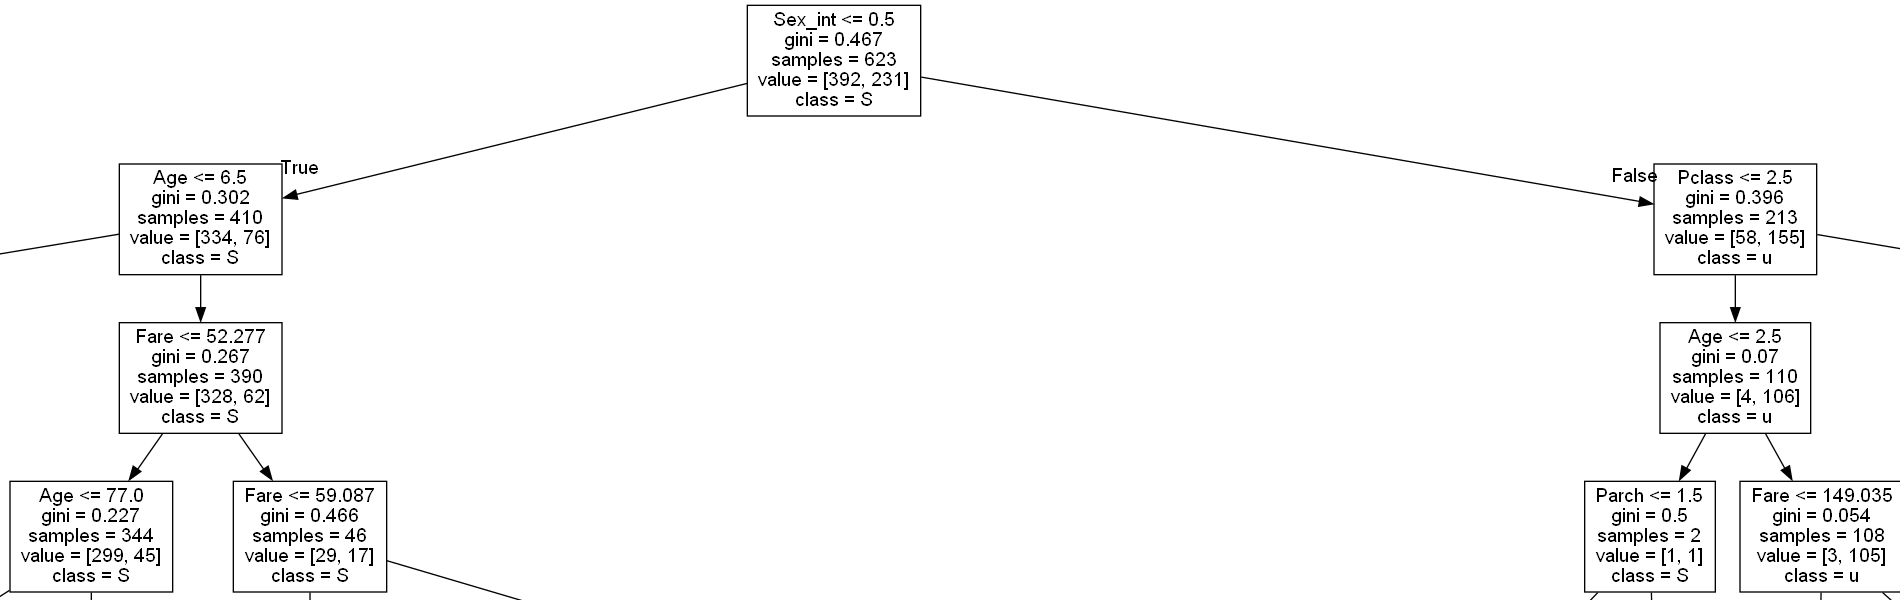

In [68]:
# Generate the visualization of the decision tree model
dot_data = export_graphviz(cfl, out_file=None, feature_names=df_titanic_predictor.columns, class_names='Survived')

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)
png_bytes = graph.pipe(format='png')

# Create a PIL.Image object from the PNG bytes
pil_image = PIL_Image.open(io.BytesIO(png_bytes))

# Crop the PIL.Image object
left = 3200
top = 0
right = 5100
bottom = 600
cropped_pil_image = pil_image.crop((left, top, right, bottom))

# Convert the cropped PIL.Image object back to a PNG bytes object
cropped_png_bytes = io.BytesIO()
cropped_pil_image.save(cropped_png_bytes, format='png')
cropped_png_bytes = cropped_png_bytes.getvalue()

# Display the cropped image
Image(cropped_png_bytes)

In [52]:
# Explain hyperparameters!!

In [53]:
# In order to improve the model we are going to apply the hyperparameter technique which will iterate the model through different parameters and ranges
# and will choose the best ones that results in the higher accuracy

In [101]:
# Instantiate the model
model = DecisionTreeClassifier()

# Define the hyperparameters to be adjusted
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4, 5, 6],
              'min_samples_leaf': [1, 2, 3, 4, 5]}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)

# Train the GridSearchCV model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params, "\n")

# Build a new model with the best parameters
model = DecisionTreeClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'], 
                               min_samples_leaf=best_params['min_samples_leaf'])

# Train the model again with the best parameters
model.fit(X_train, y_train)

# Predict using the test sample
y_pred = model.predict(X_test)

# Calculate the accuary
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 2), "\n")

# Evaluate the model performance with the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2} 

Accuracy: 0.78 

Confusion Matrix:
 [[148   9]
 [ 50  61]]


In [102]:
 print(f"After improving the model using hyperparameters, we were able to predict correctly {round(accuracy*100, 2)}% of the cases\n \
 Being {confusion_matrix(y_test, y_pred)[0][0]} true negatives and {confusion_matrix(y_test, y_pred)[1][1]} true positives \
 of a total {len(df_titanic)} cases.\n \
 The number os nodes is {cfl.tree_.node_count}")

After improving the model using hyperparameters, we were able to predict correctly 77.99% of the cases
 Being 148 true negatives and 61 true positives of a total 891 cases.
 The number os nodes is 295


In [58]:
# Now we apply the logistic regression to evaluate which model perform better

In [103]:
# Instatiate the model
clf_lr = LogisticRegression()

# Fit the model
clf_lr.fit(X_train, y_train)

# Predict the values
y_pred = clf_lr.predict(X_test)

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred)
print(round(accuracy_lr, 2))

# Evaluate the model with the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

0.79
Confusion Matrix:
 [[134  23]
 [ 32  79]]


C:\Users\Deomar Santos\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [104]:
 print(f"Without improvements on the model, we were able to predict correctly {round(accuracy_lr*100, 2)}% of the cases\n \
 Being {confusion_matrix(y_test, y_pred)[0][0]} true negatives and {confusion_matrix(y_test, y_pred)[1][1]} true positives \
 of a total {len(df_titanic)} cases.")

Without improvements on the model, we were able to predict correctly 79.48% of the cases
 Being 134 true negatives and 79 true positives of a total 891 cases.


In [61]:
# Applying hyperparameters in the logistic regression model

In [105]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Instantiate the logistic regression model
model = LogisticRegression()

# Define the hyperparameters to be searched
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}

# Define the cross strategy
cv = 5

# Define Grid Search with the parameters
grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1)

# Train the Grid Search model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:")
print(grid_search.best_params_, "\n")

# Create a new instance of the model with the best hyperparameters
best_model = LogisticRegression(**grid_search.best_params_)

# Fit the new model on the entire training set
best_model.fit(X_train, y_train)

# Predict the results
y_pred = best_model.predict(X_test)

# Print accuracy
print("Accuracy:", round(accuracy_score(y_test, y_pred), 2), "\n")

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best parameters:
{'C': 0.1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'} 

Accuracy: 0.82 

Confusion Matrix:
[[141  16]
 [ 32  79]]


In [63]:
# The logistic regression model performed better (82% accuracy) than the decision tree model (79% accuracy) and the hyperparameter method was applied
# Both results were reasonable and do not have much difference in results

# One possible explanation why the regression model performed better is that the regression is better to predict complex relations between the variables
# than the logistic regression that is based on a set of rules that sometimes can not get all the relations in the best way

# The decision tree model is best suited for classification problems where the results are made of groups, in the other hand linear model
# are best suit for problems where the results did not perform groups given that this model approach the problem by a continumn regression not being 
# best to separate groups as the decision tree does

#### Theory

##### Chi-Square correlation

<span style="font-size: smaller">The Chi-Square correlation is nothing but an statistical test between two categorical variables that tests if one variable is dependend on the other. This test follows the foundation of any correlation calculation that, basically, is the measure of how much one result is different from an expected result or a mean value. As different it is more likely the variables are correlated because, in theory, the expected values are values that would be expected if there is no correlation at all</span>

<span style="font-size: smaller">For the chi-square test, the measure of how much different the values are from the expected is as follows:</span>

$$
\chi^2 = \sum_{i=1}^{n}\sum_{j=1}^{m} \frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}
$$

<span style="font-size: smaller">where $O_{i,j}$ are the observed values and the $E_{i,j}$ are the expected values from the variables $i$ and $j$ for $n$ observed values and $m$ variables</span>

<span style="font-size: smaller">The higher the value of $\chi^2$ the smaller the probability that the variables don't have a correlation. This probability is called <i>p-value</i> which can be extracted from the chi-square distribution given the chi-square value and the relation between the number of observed $n$ and the number of variables $m$ that is called degrees of freedom $df$ and the confidence level which shape the chi-square distribution</span>

<span style="font-size: smaller">
The degrees of freedom ($df$) is given by </span>


<span style="font-size: smaller">
$df = (n-1)(m-1)$</span>

##### Point-Biserial Correlation

<span style="font-size: smaller">On the other hand, the Point-Biserial correlation calculates the correlation between a categorical variable (dichotomous on this case) and a continuum one. Similarly, the idea here is to compare the mean values of the continuum variable on the dichotomous variable. Given here as $1$ and $0$.</span>

<span style="font-size: smaller">
The Point-Biserrial correlation $(r_{pb})$ is given by:</span>

$$r_{pb} = \frac{\bar{X_1} - \bar{X_0}}{s_p}\sqrt{\frac{n_1n_0}{n(n-1)}}$$

<span style="font-size: smaller">
Where $\bar{X_1}$ is the mean of the continuum variable on the group $1$ and $\bar{X_0}$ on the group $0$ and $S_p$ being the standard deviation which give us an idea of how distant each mean are, indicating a correlation
</span>

<span style="font-size: smaller">
The second part of the equation:</span>

$\sqrt{\frac{n_1n_0}{n(n-1)}}$

<span style="font-size: smaller">
Where $n_1$, $n_0$ and $n$ are, respectively, the number of samples of the groups $1$, $0$ and the total samples. This term is needed to get rid of effects concerning to unequal groups</span>

##### Decision Tree Model

<span style="font-size: smaller">A decision tree model is basically a model the defines a set of rules (called nodes) that decide how a target value will be predict based on the input features. For example, let's say that in a dataset women is more likely to be relaxed than men. \
    On that case the decision tree model will likely create a node that defines if the input data is from a woman, then it will classify the person as relaxed. The model can be as complex as it's needed in a way that it can create a lot of rules to get the behavior of the model.</span>

<span style="font-size: smaller">
To define the set of rules, the model needs to know which features are more important to predict the target value, for example, how correlated a feature is with the target. The decision tree model uses a different measure to find out that. For example, it could be the Entropy or the Giny criterion.
</span>

<span style="font-size: smaller">Regardless of the method used it has to tell us how good the input data can predict the target variable. For example, if we use the concept of entropy, we can measure the disorder of the system based on one feature variable. \
Let's say that if the system has a large desorder with respect to one feature, it means that this variable is likely to not separate well the target, in other words, it's not a good choice for the node. Otherwise, if the disorder is small it would be a good choice to use in the node.
</span>

<span style="font-size: smaller">
The Entropy criterion $H(S)$ is given by:</span>

$$H(S) = -\sum_{i=1}^{c} p_i \log_2{p_i}$$

<span style="font-size: smaller">Where, for a set S, $p_i$ is the proportion of samples that belong to the class $i$ for a total number $c$ of classes.</span>

<span style="font-size: smaller">The logarithm will output values between 1 and 0 in order to inform if the system is disordered (1) and 0 when the system is ordered, i.e, when a dichotomous variable is in unequal proportion. The factor $p_i$ aims to assign a weight for the class of the variable, in a way that it prevents from assign the same weight for classes that are not frequent. Below we can see how the entropy function behavior:</span>

In [70]:
Image(url='https://nulpointerexception.com/wp-content/uploads/2017/11/entropy_graph.gif?w=2048', width=500)


<span style="font-size: smaller">Source: https://nulpointerexception.com/2017/12/13/entropy-in-machine-learning/</span>

<span style="font-size: smaller">To define if creating a node based on a variable is a good choice we use a measure that compares the entropy of the general system with the entropy related to the variable, this measure is called Information Gain (IG) and is given as above:</span>

$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

<span style="font-size: smaller">
Where S is the set, $A$ the feature, $Values(A)$ the group of features, $v$ the class, $S_v$ the number of data labeled as v and $|H(S_v)|$ is the entropy of the set V labeled as $v$ and $S$ the number of data in the group $|S|$. </span>

<span style="font-size: smaller">This way the features that maximizes the information gain should be used in the nodes, where the features with the highest values should be chosen first. \
\
For continuum features, the IG must be calculated for all the range in order to find the best split for the nodes.</span>

##### Logistic Regression Model

<span style="font-size: smaller">The logistic regression model is based on the linear regression model that assumes linear relationships between the features and the target. \
To use linear models for categorical variables, we need to use a function that transforms a continum variable to a categorical variable. For example, if the target is dichotomous, we use a logistic function that transforms a cotinuum range to a binary, so in this case the model will be called logistic regression.
</span>

<span style="font-size: smaller">We use a logistic function that transforms a cotinuum range to a binary variable of 0 and 1 called sigmoid function that is given by:
</span>

\begin{equation}
h(x) = \frac{1}{1+\exp[-(\beta_0 + \beta_1 x_1 + \dots + \beta_p x_p)]}
\end{equation}

<span style="font-size: smaller">Where h is the target value, $\beta_i$ the parameter the aproximates the target value, and $x$ the features.</span>

<span style="font-size: smaller">The output will be in the range between 0 and 1 (as can be seen in the figure below). To generate the binary variable, if the $h(x)$ is less than 0.5 we choose 0 as the outcome, otherwise we choose 1.</span>

In [75]:
Image(url='https://hvidberrrg.github.io/deep_learning/activation_functions/assets/sigmoid_function.png', width=500)

<span style="font-size: smaller">Source: https://hvidberrrg.github.io/deep_learning/activation_functions/sigmoid_function_and_derivative.html</span>

<span style="font-size: smaller">Given that, now we need a method to approximate the best values for parameters $\beta_i$ to predict the target value.</span>

<span style="font-size: smaller">One approach can be calculate the difference between the predict values and the real values and try to minimize the errors. Once that is done, we just need to find the parameters that minimizes the erros.</span>

<span style="font-size: smaller">To calculate the errors we use a cost function called cross-entropy that penalizes large errors and has only one minimum so it's easier to minimize. The cross-entropy cost function $J(\theta)$ is given by:</span>

\begin{equation}
J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \left[y^{(i)}\log(h_{\beta}(x^{(i)})) + (1-y^{(i)})\log(1-h_{\beta}(x^{(i)}))\right]
\end{equation}

<span style="font-size: smaller">Where $m$ is the size of the dataset, $y^{i}$ is the actual target value, $h_{\beta}(x^{(i)})$ the predicted value and $i$ is the index of the data.
</span>

<span style="font-size: smaller">The term $y^{(i)}\log(h_{\beta}(x^{(i)}))$ penalizes when it is predicted low values for a positive target and the $(1-y^{(i)})\log(1-h_{\beta}(x^{(i)}))$ when it is predicted large values for a negative target. The use of logarithm increases the penalization.
</span>

<span style="font-size: smaller">Now that we have a cost function, we can find the better parameters by minimizing the function. To do this we use the gradient descent algorithm.
</span>

<span style="font-size: smaller">The gradient descent algorithm is based on iterating a parameter in the direction that minimizes a function
    to find the minimum value of the function, which is the goal of what we mentioned. In a math notation it is the following:</span>

$$\beta_{j(t+1)} = \beta_{j(t)} - \alpha\frac{\partial J(\beta)}{\partial \beta_j(t)}$$

<span style="font-size: smaller">The $\beta_{t+1}$ is the updated parameter, $\beta_{j(t)}$ is the actual parameter, $\alpha$ is the rate or step we take every iteration and $\frac{\partial J(\beta)}{\partial \beta_j(t)}$ represents the parcial derivative that defines the direction of the iteration.</span>

<span style="font-size: smaller">The equation with the derivated cost function is:</span>

$$\beta_j(t+1) = \beta_j(t) - \alpha \sum_{i=1}^m (h_{\beta}(x^{(i)}) - y^{(i)})x_j^{(i)}$$